In [15]:
from music21 import converter, instrument, note, chord
import json
import sys
import numpy as np
from imageio import imwrite
import sys
import matplotlib.pyplot as plt

In [16]:
def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

In [17]:
def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))
                
        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element.notes:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}

In [66]:
def midi2image(midi_path, reps = 1):
    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)

    data = {}

    try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()

            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = get_notes(notes_to_parse)
                i+=1
            else:
                data[instrument_i.partName] = get_notes(notes_to_parse)

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0".format(i)] = get_notes(notes_to_parse)

    resolution = 0.25

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems
        upperBoundNote = 127
        lowerBoundNote = 21
        maxSongLength = 1000

        index = 0
        prev_index = 0
        repetitions = 0
        while repetitions < reps:
            if prev_index >= len(values["pitch"]):
                break

            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))

            pitchs = values["pitch"]
            durs = values["dur"]
            starts = values["start"]

            for i in range(prev_index,len(pitchs)):
                pitch = pitchs[i]

                dur = int(durs[i]/resolution)
                start = int(starts[i]/resolution)

                if dur+start - index*maxSongLength < maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255
                else:
                    prev_index = i
                    break

            matrix = (matrix * 255 / np.max(matrix)).astype('uint8')
            imwrite("output/"+midi_path.split("/")[-1].replace(".mid",f"_{instrument_name}_{index}.png"),matrix)
            print(np.max(matrix))
            plt.imshow(matrix, cmap='gray', aspect='auto')
            index += 1
            repetitions+=1

255


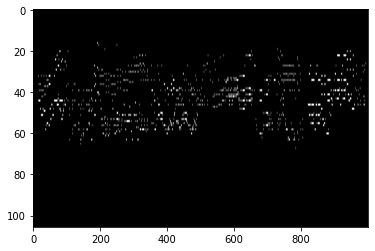

In [67]:
midi_path = "../musical_chess/data/TPD/classical/ADIG01.mid"
midi2image(midi_path, reps = 1)

255


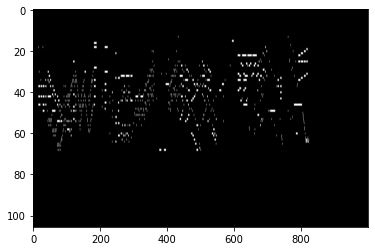

In [68]:
midi_path = "../musical_chess/data/TPD/classical/BENABD01.mid"
midi2image(midi_path, reps = 1)

[[  0   0  20 246  25   2 205 204   1 255]]


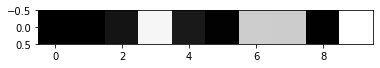

In [64]:
game_array = np.array([[0,0,0.04,-0.02,0.05, 0.005, -0.1, 0.4, -0.5,0.5]])
game_array = (game_array * 255 / np.max(game_array)).astype('uint8')
print(game_array)
plt.imshow(game_array, cmap='gray')

In [44]:
imwrite("game_img.png", game_array)

Lossy conversion from float64 to uint8. Range [-0.5, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
